# Hidden Markov Models

This notebook goes over the calculation of $\alpha$ and $\beta$ terms, which represent the forward and backward likelihoods, or *unnormalized* posterio probabilities

In previous notebooks, we have worked with forward and backward *probabilities*, the alpha and beta terms are just the inverses:

$$ P(x_t = i | Y^t) \quad \to \quad P(Y^t | x_t = i) \propto \alpha_t(i) $$
$$ P(x_t = i | Y^{t+1, T}) \quad \to \quad P(Y^{t+1, T} | x_t = i) \propto \beta_t(i) $$

Now, in practice, we need these $\alpha$ and $\beta$ terms because the calculation of the hidden state transition probability $P(x_t=i, x_{t+1}=j | Y^T)$ turns out to be easier with these alpha and beta probabilities.

Quantitatively (much like the forward and backward probabilities) the $\alpha$ and $\beta$ probabilities are calcualted recursively. For the forward likelihood. The initial state is simply given by the column vector of the observation matrix $\boldsymbol{B}$ corresponding to the initial observation:

$$ \alpha_0 = \left[\begin{matrix} \alpha_0(0) \\ \alpha_0(1) \end{matrix}\right] = \left[\begin{matrix} B_{00} \\ B_{01} \end{matrix}\right] $$

To calculate the value of $\alpha_t$ for other $t$, we simply propogate the intial condition forward in time using (See Ref.[1])

$$ \alpha_{t+1}^{(j)} = \sum_i \alpha_t(i) A_{ji} b_j(y_{t+1})  $$

where $b_j(y_{t+1})$ is the $j$th row of column $y_{t+1}$ in the observation matrix (where here $y_{t+1}$ is the observation at time $t+1$)

Similarly, the backward likelihoods are initialized with the condition that

$$ \beta_{T-1}(i) = 1 $$

and then satisfy the similar (backwards) recurrence

$$ \beta_{t-1}(i) = \sum_j A_{ji}b_j(y_{t})\beta_t(j) $$

Using these two relationships, we can end up wth the full sequence of $\alpha$ and $\beta$ vectors.

#### References

-[1] W.H. Press, S.A. Teukolsky, & B.P. Flannery, *Numerical Recipes: The Art of Scientific Computing*, **2007**, Cambridge University Press


In [146]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from hidden import dynamics


In [147]:
a = 0.9
b = 0.8

# We introduce a slight asymmetry here just to make sure the later vectorized
# calculations are actually correct
delta = 0.01

A = np.array([[a + delta, 1 - a ], [1 - a - delta, a]])
B = np.array([[b - delta, 1 - b], [1 - b + delta, b]])

# Instantiate the simulator
hmm = dynamics.HMM(2, 2)

# Initialize the dynamics
hmm.initialize_dynamics(A, B)

# And run the dynamics for 100 steps
hmm.run_dynamics(100)


In [148]:
# Now, we can pull out the states and observation time series'
state_ts = hmm.get_state_ts()
obs_ts = hmm.get_obs_ts()

In [149]:
# Now we want to calculate the first few alpha terms

alpha = B[:, obs_ts[0]]
alpha

array([0.79, 0.21])

In [150]:
# Now, we can explicitly calcualte the alpha_1 term as

alpha_0 = alpha.copy()

alpha_1_0 = (alpha_0[0] * A[0, 0] * B[0, obs_ts[1]]) + (alpha_0[1] * A[0, 1] * B[0, obs_ts[1]])
alpha_1_1 = (alpha_0[0] * A[1, 0] * B[1, obs_ts[1]]) + (alpha_0[1] * A[1, 1] * B[1, obs_ts[1]])

alpha_1_0, alpha_1_1


(0.5845210000000001, 0.05462099999999999)

In [151]:
# However, we can factor out the B terms from each expression, and even vectorize the expression as
((A @ alpha_0) * B[:, obs_ts[1]])

array([0.584521, 0.054621])

In [152]:
# And therefore, we can vectorize the entire calculation as
alpha = B[:, obs_ts[0]]
alpha_tracker = [alpha]

for obs in obs_ts[1:]:
    alpha = (A @ alpha) * B[:, obs]
    alpha_tracker.append(alpha)


In [153]:
# And these first few terms match our expectations from the previous calculation
alpha_tracker[0], alpha_tracker[1]

(array([0.79, 0.21]), array([0.584521, 0.054621]))

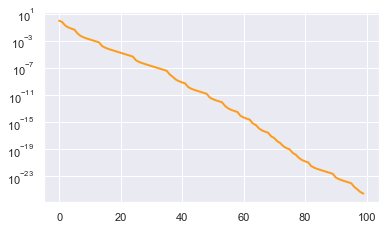

In [154]:
# To show that these are not normalized probabilities, we can look at the
# normalization over time

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
# Intuitively, this makes sense because, the likelihood of any given trajectory
# conditioned on a single current state will go down fast as that trajectory
# gets longer

ax.plot([np.sum(a) for a in alpha_tracker], linewidth=2.0, color=sns.xkcd_rgb["tangerine"], alpha=0.9)
ax.set_yscale('log')

In [156]:
# Now for the beta terms:

# Initial value is
beta = np.ones(2)
beta_T = beta.copy()
beta_T

array([1., 1.])

In [157]:
# And then we can calcualte the next term explicitly (as before)

beta_Tm1_0 = (A[1, 0] * B[1, obs_ts[-1]] * beta_T[1]) + (A[0, 0] * B[0, obs_ts[-1]] * beta_T[0])
beta_Tm1_1 = (A[1, 1] * B[1, obs_ts[-1]] * beta_T[1]) + (A[0, 1] * B[0, obs_ts[-1]] * beta_T[0])

beta_Tm1_0, beta_Tm1_1

(0.25399999999999995, 0.7400000000000001)

In [158]:
# This can also be sort-of vectorized, not quite as cleanly as the previous
# calculation, as the B terms are also contained in the summation. Howvever
# this isnt so bad, and we just have to do an element-wise multiplication of
# B[:, obs] by beta_T before the matrix multiplication by A (transpose)

A.T @ (B[:, obs_ts[-1]] * beta_T)


array([0.254, 0.74 ])

In [159]:
# So, with this we can also generate the entire sequence of beta
# values

beta = np.ones(2)
beta_tracker = [beta]
# Loop over observations from T-1 --> 0
for obs in obs_ts[-1::-1]:
    beta = A.T @ (beta * B[:, obs])
    beta_tracker.append(beta)

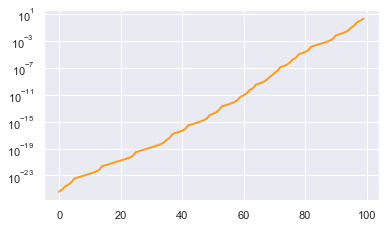

In [174]:
# As of now, the beta_tracker has its 0 element corresponding to t=T and its
# final element being t=0 so we can swap the ordering so that alpha and beta
# are in the same index reference frame

# Here beta_tracker fwd is the 'forward time' version
beta_tracker_fwd = beta_tracker[::-1][1:]

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.plot([np.sum(b) for b in beta_tracker_fwd], linewidth=2.0, color=sns.xkcd_rgb["tangerine"], alpha=0.9)
ax.set_yscale('log')

In [175]:
len(alpha_tracker), len(beta_tracker_fwd)

(100, 100)

(2.1965091246574612e-26, 2.6846222634702304e-26)

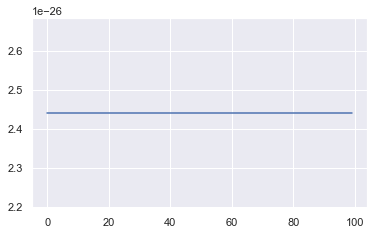

In [184]:
# Now, as a test, the likelihood (total) should be independent of t, and can be
# written as a function of alpha and beta as
# L_t = \sum_i \alpha_t(i) * beta_t(i)

likelihood = [np.sum(a * b) for a, b in zip(alpha_tracker, beta_tracker_fwd)]

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.plot(likelihood)
ax.set_ylim([np.mean(likelihood) * 0.9, np.mean(likelihood) * 1.1])

In [178]:
# This is reasonable? We can also calcualte the Bayesian Smoothed probability
# supposedly, from the alpha, beta, and likelihood terms

# the probability of a given hidden state i at time t is alpha_t(i) * beta_t(i) / likelihood_t

# So, for instance, at t=10, we can get the bayesian probability as
bayes_p_0 = alpha_tracker[10][0] * beta_tracker_fwd[10][0] / likelihood[10]
bayes_p_1 = alpha_tracker[10][1] * beta_tracker_fwd[10][1] / likelihood[10]

# So, from this we can see that this is, in fact, a probability, and that
# there is a high probability of the system being in state 1
bayes_p_0, bayes_p_1, sum([bayes_p_0, bayes_p_1])

(0.005871458919184878, 0.994128541080815, 0.9999999999999999)

In [179]:
# We can then trivially (again) get this vector for the entire time series
bayes_tracker = []

for a, b, l in zip(alpha_tracker, beta_tracker_fwd, likelihood):
    bayes_tracker.append(a * b / l)

bayes_tracker[:5]

[array([0.91212254, 0.08787746]),
 array([0.91479517, 0.08520483]),
 array([0.84131683, 0.15868317]),
 array([0.8985316, 0.1014684]),
 array([0.87886763, 0.12113237])]

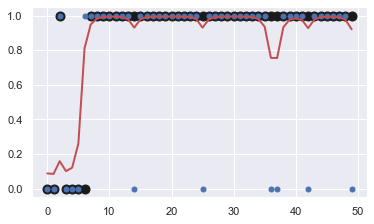

In [181]:
prob_1 = [b[1] for b in bayes_tracker]

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.plot(state_ts[:50], 'o', markersize=9, color='k', label="State")
ax.plot(obs_ts[:50], 'o', markersize=5, color='b', label="Observation")
ax.plot(prob_1[:50], linewidth=2.0, color='r')



In [182]:
# Now, we can also run the Baum-Welch algorithm on this system
# To start, we can re-initialize the system
from hidden import infer

hmm = dynamics.HMM(2, 2)
hmm.initialize_dynamics(A, B)
hmm.run_dynamics(200)

obs_ts, state_ts = hmm.get_obs_ts(), hmm.get_state_ts()

In [183]:
a, b = 0.9, 0.8
delta_2 = 0.05

A_est = np.array([[a + delta_2, 1 - a ], [1 - a - delta_2, a]])
B_est = np.array([[b - delta_2, 1 - b], [1 - b + delta_2, b]])


In [117]:
bayes_infer = infer.MarkovInfer(2, 2)

bayes_infer.alpha(A_est, B_est, obs_ts)
bayes_infer.beta(A_est, B_est, obs_ts)

In [119]:
# Now, we can update the elements of the hidden matrix

# Note that this is done through the formula
# numer = \sum_t alpha_t(i) * A_{ji} * beta_{t+1}(j) * B[j, obs_t+1]
# denom = \sum_t alpha_t(i) * \beta_t(i)
# A_ji_new = numer / denom

# We can calculate a sample term the the top summation

# say for i,j = 0, 1
numer_10_01 = bayes_infer.alpha_tracker[10][1] * A[0, 1] * bayes_infer.beta_tracker[11][0] * B_est[0, obs_ts[11]]
denom_10_01 = bayes_infer.alpha_tracker[10][1] * bayes_infer.beta_tracker[10][1]

numer_10_01 / denom_10_01

0.6161309478285064

In [128]:
# Now we can calculate this for each term
# First we can do it term-by-term
alpha_0 = [a[0] for a in bayes_infer.alpha_tracker]
alpha_1 = [a[1] for a in bayes_infer.alpha_tracker]
beta_0 = [b[0] for b in bayes_infer.beta_tracker]
beta_1 = [b[1] for b in bayes_infer.beta_tracker]

A_new_00 = np.sum([a * A_est[0, 0] * b * B_est[o, 0] for a, b, o in zip(alpha_0[:-1], beta_0[1:], obs_ts[1:])]) / np.sum([a * b for a, b in zip(alpha_0[:-1], beta_0[:-1])])
A_new_11 = np.sum([a * A_est[1, 1] * b * B_est[o, 1] for a, b, o in zip(alpha_1[:-1], beta_1[1:], obs_ts[1:])]) / np.sum([a * b for a, b in zip(alpha_1[:-1], beta_1[:-1])])
A_new_10 = np.sum([a * A_est[1, 0] * b * B_est[o, 1] for a, b, o in zip(alpha_0[:-1], beta_1[1:], obs_ts[1:])]) / np.sum([a * b for a, b in zip(alpha_0[:-1], beta_0[:-1])])
A_new_00 = np.sum([a * A_est[0, 1] * b * B_est[o, 0] for a, b, o in zip(alpha_1[:-1], beta_0[1:], obs_ts[1:])]) / np.sum([a * b for a, b in zip(alpha_1[:-1], beta_1[:-1])])

In [130]:
A_new_00

0.10989998390926506

In [132]:
A

array([[0.91, 0.1 ],
       [0.09, 0.9 ]])